In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import sys
sys.path.insert(0, '../..')

import quan_utils

In [2]:
import gpflow
import gpflowopt

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/quannguyen/anacond

In [3]:
NUM_SAMPLES = 5
BUDGET = 20

# Both objective functions
def f(constraint):
    helper = quan_utils.AssignmentHelper()
    helper.update_constraints(fairness_constraint=constraint)
    
    sol_df = helper.ip_solve()
    real_n_reentries, bart_n_reentries, sol_n_reentries = helper.compare_reentry(sol_df, verbose=False)
    prob_compare_df = helper.compare_prob(sol_df)
    
    return np.hstack(
        ([[- (real_n_reentries - sol_n_reentries) / real_n_reentries * 100]],
        [[prob_compare_df['Diff'].quantile(0.75)]])
    )

In [4]:
# Input domain
domain = gpflowopt.domain.ContinuousParameter('constraint', 0, 0.2)
design = gpflowopt.design.RandomDesign(NUM_SAMPLES, domain)
X = design.generate()
X

array([[0.04003719],
       [0.12749309],
       [0.00367423],
       [0.18838137],
       [0.04402906]])

In [5]:
Y = np.array([f(x) for x in X]).reshape(NUM_SAMPLES, 2)
# Y

In [6]:
# Y.shape

In [7]:
# Y[:, [0]]

In [8]:
# One model for each objective
objective_models = [gpflow.gpr.GPR(X.copy(), Y[:, [i]].copy(),
                                   gpflow.kernels.Matern52(1, ARD=True))
                    for i in range(Y.shape[1])]

for model in objective_models:
    model.likelihood.variance = 0.01
    
hvpoi = gpflowopt.acquisition.HVProbabilityOfImprovement(objective_models)

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/acquisition.py:193: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self.models[0].X.value, np.hstack(map(lambda model: model.Y.value, self.models))


In [9]:
# Combine MC step followed by L-BFGS-B
acquisition_opt = gpflowopt.optim.StagedOptimizer([
    gpflowopt.optim.MCOptimizer(domain, 1000),
    gpflowopt.optim.SciPyOptimizer(domain)
])

# Run BO for 5 iterations
optimizer = gpflowopt.BayesianOptimizer(
    domain, hvpoi, optimizer=acquisition_opt
)

result = optimizer.optimize(f, n_iter=BUDGET)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/hvpoi.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  F = np.hstack((m.predict_f(feasible_samples)[0] for m in self.models))


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/bo.py:150: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  evaluations = np.hstack(map(lambda f: f(X), fxs))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/acquisition.py:193: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self.models[0].X.value, np.hstack(map(lambda model: model.Y.value, self.models))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/hvpoi.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterabl

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/acquisition.py:193: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return self.models[0].X.value, np.hstack(map(lambda model: model.Y.value, self.models))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/hvpoi.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  F = np.hstack((m.predict_f(feasible_samples)[0] for m in self.models))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/bo.py:150: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/hvpoi.py:92: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  F = np.hstack((m.predict_f(feasible_samples)[0] for m in self.models))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/bo.py:150: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  evaluations = np.hstack(map(lambda f: f(X), fxs))
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/gpflowopt/acquisition/acquisition.py:193: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as genera

In [10]:
result

 constraints: array([], shape=(20, 0), dtype=float64)
         fun: array([[-1.08140027e+01,  3.91582765e-02],
       [-1.09623023e+01,  3.92763140e-02],
       [-1.06347221e+01,  3.57259140e-02],
       [-9.59244130e+00,  2.58556420e-02],
       [-8.70533979e+00,  1.26751810e-02],
       [-9.12177120e+00,  2.07822425e-02],
       [-1.09140061e+01,  3.92451315e-02],
       [-1.07695070e+01,  3.91156495e-02],
       [-1.01002722e+01,  2.83878745e-02],
       [-8.26498688e+00,  0.00000000e+00],
       [-1.03614713e+01,  3.17210740e-02],
       [-9.82706861e+00,  2.66219335e-02],
       [-9.33983747e+00,  2.33398110e-02],
       [-1.09688029e+01,  3.92823560e-02],
       [-8.49693950e+00,  4.27431200e-03],
       [-8.89750657e+00,  1.80507205e-02],
       [-1.09353746e+01,  3.92546185e-02],
       [-1.08697151e+01,  3.92077415e-02],
       [-1.06880716e+01,  3.89654350e-02],
       [-1.04913699e+01,  3.32339920e-02]])
     message: 'OK'
        nfev: 20
     success: True
           x: ar

In [11]:
optimizer.acquisition.pareto.front.value

array([[-1.09687969e+01,  3.91600952e-02],
       [-1.08697001e+01,  3.91380157e-02],
       [-1.08140012e+01,  3.90925117e-02],
       [-1.07687191e+01,  3.90620692e-02],
       [-1.06893219e+01,  3.88899495e-02],
       [-1.06346242e+01,  3.57211249e-02],
       [-1.03602240e+01,  3.13639373e-02],
       [-1.00979731e+01,  2.86837501e-02],
       [-9.83265527e+00,  2.71252288e-02],
       [-9.59145749e+00,  2.58437433e-02],
       [-9.33572725e+00,  2.35575708e-02],
       [-9.12313032e+00,  2.04451022e-02],
       [-8.90678756e+00,  1.61101388e-02],
       [-8.69952701e+00,  1.12612991e-02],
       [-8.48169247e+00,  6.27951989e-03],
       [-8.26857556e+00,  2.38395508e-03],
       [-8.06142462e+00, -4.46686313e-05],
       [-7.75920503e+00, -1.33894107e-03]])

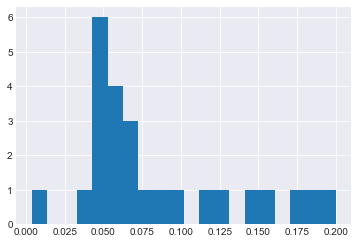

In [22]:
plt.hist(hvpoi.data[0], bins=20)
plt.show()

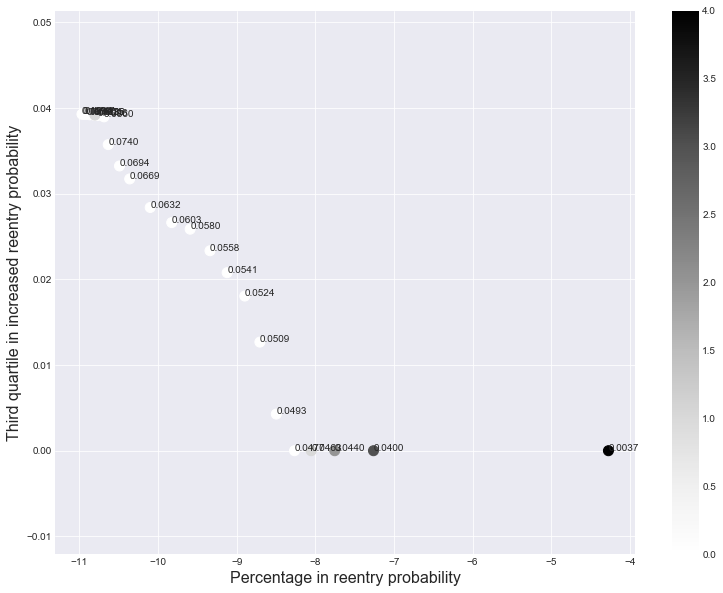

In [12]:
plt.figure(figsize=(13, 10))

_, dom = gpflowopt.pareto.non_dominated_sort(hvpoi.data[1])

plt.scatter(
    hvpoi.data[1][:, 0],
    hvpoi.data[1][:, 1],
    c=dom,
    s=100
)
plt.colorbar()

for i, constraint in enumerate(hvpoi.data[0]):
    plt.annotate(
        f'{float(constraint):.4f}',
        (hvpoi.data[1][i, 0], hvpoi.data[1][i, 1]),
        fontsize=10
    )

plt.xlabel('Percentage in reentry probability', fontsize=16)
plt.ylabel('Third quartile in increased reentry probability', fontsize=16)
    
plt.show()

# Scratch paper

In [13]:
optimizer.acquisition.data[1].shape[1]

2

In [14]:
np.atleast_1d(1)

array([1])

In [15]:
np.hstack(map(lambda x: (0, 1), [1])).shape[1]

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


IndexError: tuple index out of range

In [16]:
np.hstack(([[0]], [[1]])).shape

(1, 2)

In [17]:
np.array([np.hstack(([[0]], [[1]])) for _ in range(3)]).reshape(3, 2).shape

(3, 2)

In [18]:
optimizer.acquisition.pareto.front.value[:, 0].shape

(18,)

In [19]:
result.x.flatten().shape

(20,)

In [20]:
hvpoi.data

(array([[0.04003719],
        [0.12749309],
        [0.00367423],
        [0.18838137],
        [0.04402906],
        [0.07398914],
        [0.05799637],
        [0.05085603],
        [0.05406317],
        [0.15902568],
        [0.10063836],
        [0.06321163],
        [0.04774985],
        [0.0668808 ],
        [0.06029867],
        [0.05578106],
        [0.19992699],
        [0.04927652],
        [0.05239676],
        [0.17467135],
        [0.14384141],
        [0.08601349],
        [0.04625999],
        [0.11360579],
        [0.06937648]]), array([[-7.26032864e+00,  0.00000000e+00],
        [-1.08140027e+01,  3.91582765e-02],
        [-4.27160033e+00,  0.00000000e+00],
        [-1.09623023e+01,  3.92763140e-02],
        [-7.75384347e+00,  0.00000000e+00],
        [-1.06347221e+01,  3.57259140e-02],
        [-9.59244130e+00,  2.58556420e-02],
        [-8.70533979e+00,  1.26751810e-02],
        [-9.12177120e+00,  2.07822425e-02],
        [-1.09140061e+01,  3.92451315e-02],
        [

In [21]:
dom

array([3, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0])